# Item-based collaborative filtering

In [1]:
import pandas as pd
import re 
from pprint import pprint
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('./Dataset/train_healthy.csv')
test_data = pd.read_csv('./Dataset/test_dataset_all.csv')

## Create a copy of train and test dataset
* Dummy train will be used later for prediction of the recipes not rated by user. To ignore the recipes rated by the user, it is mark 0 during prediction. The recipes not rated by user is marked as 1 for prediction
* Dummy test will be used for evaluation. To evaluate, predictions are made on recipes rated by the user where it is marked as 1. This is the opposite of dummy_train

In [3]:
# make a copy of train and test datasets
dummy_train = train_data.copy()
dummy_test = test_data.copy()

dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x > 0 else 1)
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
dummy_train = dummy_train[['user_id','recipe_id','rating']]
dummy_test = dummy_test[['user_id','recipe_id','rating']]

In [5]:
# The recipes not rated by user is marked as 1 for prediction 
dummy_train = dummy_train.pivot_table(index = 'user_id', columns = 'recipe_id', values = 'rating').fillna(1)

# The recipes not rated by user is marked as 0 for evaluation 
dummy_test = dummy_test.pivot_table(index ='user_id', columns = 'recipe_id', values = 'rating').fillna(0)


In [6]:
dummy_train

recipe_id,40,41,46,62,85,91,142,153,170,174,...,391941,391956,392017,392181,392342,392542,392644,392712,440074,462980
user_id,,,,,,,,,,,,,,,,,,,,,
1535,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2310,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4439,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6258,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6651,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058097,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1105991,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1329782,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
dummy_test

recipe_id,62,142,198,246,271,346,376,379,519,543,...,391372,391435,391493,391576,391602,391680,391765,391956,392342,462980
user_id,,,,,,,,,,,,,,,,,,,,,
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1105991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1329782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Item-Item (cosine similarity based on ratings)

In [8]:
recipe_features = train_data.pivot_table(index = 'recipe_id', columns = 'user_id', values = 'rating').fillna(0)
recipe_features

user_id,1535,2310,4439,6258,6651,7108,8629,10033,11176,11297,...,953275,962690,993604,1052873,1056692,1058097,1105991,1329782,1365025,1366254
recipe_id,,,,,,,,,,,,,,,,,,,,,
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
392644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
392712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# Item Similarity Matrix using Cosine similarity as a similarity measure between Items
item_similarity = cosine_similarity(recipe_features)
item_similarity[np.isnan(item_similarity)] = 0
print(item_similarity)
print("- "*10)
print(item_similarity.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
- - - - - - - - - - 
(64835, 64835)


In [10]:
rating_similarity_matrix = pd.DataFrame(item_similarity,index=recipe_features.index,columns=recipe_features.index)
rating_similarity_matrix

recipe_id,40,41,46,62,85,91,142,153,170,174,...,391941,391956,392017,392181,392342,392542,392644,392712,440074,462980
recipe_id,,,,,,,,,,,,,,,,,,,,,
40,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392542,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
392644,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
392712,0.0,0.0,0.0,0.0,0.0,0.0,0.441726,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
rating = pd.pivot_table(test_data, values = 'rating', index=['recipe_id'], columns = ['user_id'])
rating

user_id,1535,4439,6258,6651,7108,8629,11176,11297,13483,13593,...,953275,962690,993604,1052873,1056692,1058097,1105991,1329782,1365025,1366254
recipe_id,,,,,,,,,,,,,,,,,,,,,
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Get recipe that is rated 5 for each user
rating5 = rating[rating == 5]
rating5= rating5.T

# Recommend Recipes

## Without health score

In [13]:
def recommend(user_id, similarity_matrix):
    
    top_rated_recipes = rating[rating5.loc[user_id] == 5].index.values
    
    already_used = dummy_train.columns[dummy_train.loc[user_id] == 0].to_list()
    
    recommend = {}

    for i in top_rated_recipes:
        high_sim_scores = similarity_matrix.loc[i].sort_values(ascending = False)
        for i, score in high_sim_scores.iteritems():
            if score >= 0.5:
                if i in recommend:
                    if recommend[i] < score:
                        recommend[i] = score    # replace with higher score
                else:
                    recommend[i] = score
                    
    recc_dict = dict(sorted(recommend.items(),key=lambda x:x[1],reverse=True))
    recipe_id = list(recc_dict.keys())

    top_3 = recipe_id[0:3]
    top_5 = recipe_id[0:5]
    top_10 = recipe_id[0:10]
    
    return {'top_3': top_3, 'top_5': top_5, 'top_10': top_10}

In [14]:
def evaluate(user_id, similarity_matrix):
    
    # prediction
    predicted_recipe = recommend(user_id, similarity_matrix)
    
    # actual
    actual_recipe = dummy_test.columns[dummy_test.loc[user_id] == 1].to_list()
    
    # count no. of recipes predicted correctly
    # top 3
    num_correct_top3 = 0
    for i in predicted_recipe['top_3']:
        if i in actual_recipe:
            num_correct_top3 += 1
    
    correct_top3 = False        # False - all predictions are wrong
    if num_correct_top3 > 0:
        correct_top3 = True     # True - at least one prediction correct
            
    # top 5
    num_correct_top5 = 0
    for i in predicted_recipe['top_5']:
        if i in actual_recipe:
            num_correct_top5 += 1
    
    correct_top5 = False        # False - all predictions are wrong
    if num_correct_top5 > 0:
        correct_top5 = True     # True - at least one prediction correct
    
    # top 10
    num_correct_top10 = 0
    for i in predicted_recipe['top_10']:
        if i in actual_recipe:
            num_correct_top10 += 1
    
    correct_top10 = False        # False - all predictions are wrong
    if num_correct_top10 > 0:
        correct_top10 = True     # True - at least one prediction correct
    
    
    return {'top_3': (num_correct_top3, correct_top3,), 
            'top_5': (num_correct_top5, correct_top5),
            'top_10': (num_correct_top10, correct_top10),
            'actual_recipe': len(actual_recipe)}

In [15]:
result_df = pd.DataFrame(columns=['Top 3_num correct', 'Top 3_success', 'Top 5_num correct', 'Top 5_success',
                                      'Top 10_num correct', 'Top 10_success', 'actual_count'])

for i in dummy_test.index:
    
    result = evaluate(i,rating_similarity_matrix)    

    result_df.loc[i] = {'Top 3_num correct': result['top_3'][0], 'Top 3_success': result['top_3'][1], 
                        'Top 5_num correct': result['top_5'][0], 'Top 5_success': result['top_5'][1],
                        'Top 10_num correct': result['top_10'][0], 'Top 10_success': result['top_10'][1], 
                        'actual_count': result['actual_recipe']}

result_df

,Top 3_num correct,Top 3_success,Top 5_num correct,Top 5_success,Top 10_num correct,Top 10_success,actual_count
1535,3,True,5,True,6,True,73
4439,0,False,0,False,0,False,49
6258,3,True,5,True,8,True,23
6651,3,True,3,True,3,True,52
7108,1,True,1,True,1,True,14
...,...,...,...,...,...,...,...
1058097,3,True,5,True,9,True,155
1105991,3,True,5,True,6,True,80
1329782,3,True,5,True,7,True,121
1365025,3,True,5,True,8,True,161


### Precision, Recall, Weighted F-scores

If the user has used at least one of the recipe, the system has done a successful recommendation

* Precision - % of recipes used out of recommended recipes
* Recall - Out of the recipes used, % of recipes recommended

In [16]:
overall_evaluation = pd.DataFrame(columns = ['Precision', 'Recall', 'F-score'], 
                                  index = [3, 5, 10])
overall_evaluation

,Precision,Recall,F-score
3,NaN,NaN,NaN
5,NaN,NaN,NaN
10,NaN,NaN,NaN


In [17]:
beta_sq = 0.5 ** 2

for i in overall_evaluation.index:
    
    # Precision
    precision = result_df[f'Top {i}_success'].sum() / len(result_df)
    overall_evaluation.loc[i]['Precision'] = precision
    
    # Recall
    recall_table = result_df[f'Top {i}_num correct'] / result_df['actual_count']
    recall = recall_table.mean()
    overall_evaluation.loc[i]['Recall'] = recall 
    
    # F-score
    fscore = ((1 + beta_sq) * precision * recall) / ((beta_sq * precision) + recall)
    overall_evaluation.loc[i]['F-score'] = fscore
    
overall_evaluation

,Precision,Recall,F-score
3,0.934375,0.0862026,0.314831
5,0.934375,0.113136,0.381102
10,0.934375,0.141544,0.440689


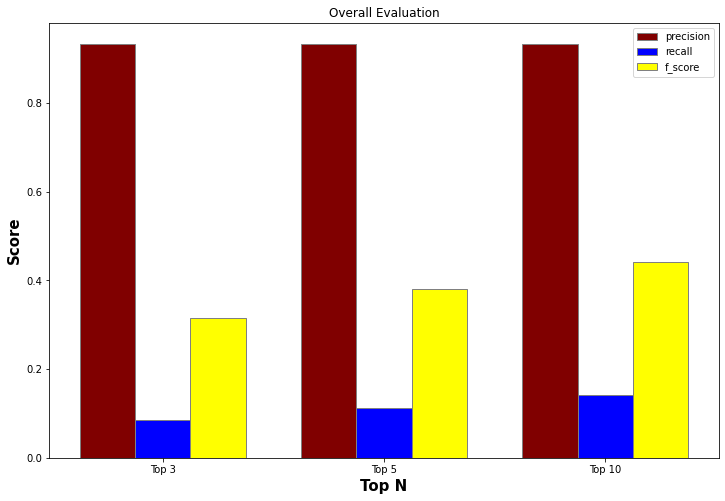

In [18]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
precision = overall_evaluation['Precision']
recall = overall_evaluation['Recall']
f_score = overall_evaluation['F-score']
 
# Set position of bar on X axis
br1 = np.arange(len(precision))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, precision, color ='maroon', width = barWidth,
        edgecolor ='grey', label ='precision')
plt.bar(br2, recall, color = 'blue', width = barWidth,
        edgecolor ='grey', label ='recall')
plt.bar(br3, f_score , color ='yellow', width = barWidth,
        edgecolor ='grey', label ='f_score')
 
# Adding Xticks
plt.xlabel('Top N', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.title("Overall Evaluation")
plt.xticks([r + barWidth for r in range(len(precision))],
        ['Top 3', 'Top 5', 'Top 10'])
 
plt.legend()
plt.show()

## With Healthscore

In [19]:
def getRecipeHealthRank():
    # All recipes health rank, list of tuples
    recipeRank = {}
    ratingReader = train_data[['recipe_id','groups']]
    for index,row in ratingReader.iterrows():
            recipeID = int(row['recipe_id'])
            healthrank = int(row['groups'])
            recipeRank[recipeID] = healthrank

    return recipeRank

In [20]:
def recommend_healthy(user_id, similarity_matrix):
    
    # recipes with HealthRank
    recipes_rank = getRecipeHealthRank()
    
    top_rated_recipes = rating[rating5.loc[user_id] == 5].index.values
    
    # recipe already used by user
    already_used = dummy_train.columns[dummy_train.loc[user_id] == 0]
    
    recommend = {}

    for i in top_rated_recipes:
        high_sim_scores = similarity_matrix.loc[i].sort_values(ascending = False)
        for i, score in high_sim_scores.iteritems():
            if score >= 0.5:
                if i in recommend:
                    if recommend[i] < score:
                        recommend[i] = score    # replace with higher score
                else:
                    recommend[i] = score
                    
    recc_dict = dict(sorted(recommend.items(),key=lambda x:x[1],reverse=True))
    recipe_id = list(recc_dict.keys())[0:20]



    result = []
    compare = 0
    while len(recipe_id) > 0:
        recipe_to_compare = recipe_id[compare]
        rank = recipes_rank[recipe_to_compare]
        if len(recipe_id) == 1:
            result.append(recipe_to_compare)
            recipe_id.pop(compare)
            break
        next_rank = recipes_rank[recipe_id[compare+1]]
        if next_rank < rank and recipe_id[compare+1] not in result:
            result.append(recipe_id[compare+1])
            recipe_id.pop(compare+1)
        elif rank <= next_rank and recipe_to_compare not in result:
            result.append(recipe_to_compare)
            recipe_id.pop(compare)
        
    top_3 = result[0:3]
    top_5 = result[0:5]
    top_10 = result[0:10]

    return {'top_3': top_3, 'top_5': top_5, 'top_10': top_10}

In [21]:
def evaluate_healthy(user_id, similarity_matrix):
    
    # prediction
    predicted_recipe = recommend_healthy(user_id, similarity_matrix)
    
    # actual
    actual_recipe = dummy_test.columns[dummy_test.loc[user_id] == 1].to_list()
    
    # count no. of recipes predicted correctly
    # top 3
    num_correct_top3 = 0
    for i in predicted_recipe['top_3']:
        if i in actual_recipe:
            num_correct_top3 += 1
    
    correct_top3 = False        # False - all predictions are wrong
    if num_correct_top3 > 0:
        correct_top3 = True     # True - at least one prediction correct
            
    # top 5
    num_correct_top5 = 0
    for i in predicted_recipe['top_5']:
        if i in actual_recipe:
            num_correct_top5 += 1
    
    correct_top5 = False        # False - all predictions are wrong
    if num_correct_top5 > 0:
        correct_top5 = True     # True - at least one prediction correct
    
    # top 10
    num_correct_top10 = 0
    for i in predicted_recipe['top_10']:
        if i in actual_recipe:
            num_correct_top10 += 1
    
    correct_top10 = False        # False - all predictions are wrong
    if num_correct_top10 > 0:
        correct_top10 = True     # True - at least one prediction correct
    
    
    return {'top_3': (num_correct_top3, correct_top3,), 
            'top_5': (num_correct_top5, correct_top5),
            'top_10': (num_correct_top10, correct_top10),
            'actual_recipe': len(actual_recipe)}

In [22]:
result_df_healthy = pd.DataFrame(columns=['Top 3_num correct', 'Top 3_success', 'Top 5_num correct', 'Top 5_success',
                                      'Top 10_num correct', 'Top 10_success', 'actual_count'])

for i in dummy_test.index:
    
    result = evaluate_healthy(i,rating_similarity_matrix)    

    result_df_healthy.loc[i] = {'Top 3_num correct': result['top_3'][0], 'Top 3_success': result['top_3'][1], 
                        'Top 5_num correct': result['top_5'][0], 'Top 5_success': result['top_5'][1],
                        'Top 10_num correct': result['top_10'][0], 'Top 10_success': result['top_10'][1], 
                        'actual_count': result['actual_recipe']}

result_df_healthy

,Top 3_num correct,Top 3_success,Top 5_num correct,Top 5_success,Top 10_num correct,Top 10_success,actual_count
1535,3,True,5,True,6,True,73
4439,0,False,0,False,0,False,49
6258,3,True,5,True,8,True,23
6651,2,True,2,True,3,True,52
7108,1,True,1,True,1,True,14
...,...,...,...,...,...,...,...
1058097,3,True,5,True,9,True,155
1105991,3,True,5,True,5,True,80
1329782,3,True,5,True,6,True,121
1365025,3,True,5,True,8,True,161


### Precision, Recall, Weighted F-scores
If the user has used at least one of the recipe, the system has done a successful recommendation

* Precision - % of recipes used out of recommended recipes
* Recall - Out of the recipes used, % of recipes recommended

In [23]:
overall_evaluation_healthy = pd.DataFrame(columns = ['Precision', 'Recall', 'F-score'], 
                                  index = [3, 5, 10])
overall_evaluation_healthy

,Precision,Recall,F-score
3,NaN,NaN,NaN
5,NaN,NaN,NaN
10,NaN,NaN,NaN


In [24]:
beta_sq = 0.5 ** 2

for i in overall_evaluation_healthy.index:
    
    # Precision
    precision = result_df_healthy[f'Top {i}_success'].sum() / len(result_df_healthy)
    overall_evaluation_healthy.loc[i]['Precision'] = precision
    
    # Recall
    recall_table = result_df_healthy[f'Top {i}_num correct'] / result_df_healthy['actual_count']
    recall = recall_table.mean()
    overall_evaluation_healthy.loc[i]['Recall'] = recall 
    
    # F-score
    fscore = ((1 + beta_sq) * precision * recall) / ((beta_sq * precision) + recall)
    overall_evaluation_healthy.loc[i]['F-score'] = fscore
    
overall_evaluation_healthy

,Precision,Recall,F-score
3,0.928125,0.0825973,0.304568
5,0.93125,0.107439,0.367569
10,0.934375,0.138992,0.435707


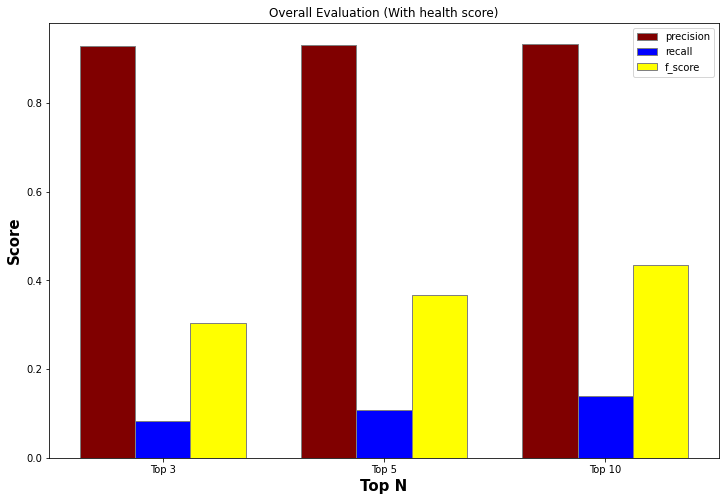

In [25]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
precision = overall_evaluation_healthy['Precision']
recall = overall_evaluation_healthy['Recall']
f_score = overall_evaluation_healthy['F-score']
 
# Set position of bar on X axis
br1 = np.arange(len(precision))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, precision, color ='maroon', width = barWidth,
        edgecolor ='grey', label ='precision')
plt.bar(br2, recall, color = 'blue', width = barWidth,
        edgecolor ='grey', label ='recall')
plt.bar(br3, f_score , color ='yellow', width = barWidth,
        edgecolor ='grey', label ='f_score')
 
# Adding Xticks
plt.xlabel('Top N', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.title("Overall Evaluation (With health score)")
plt.xticks([r + barWidth for r in range(len(precision))],
        ['Top 3', 'Top 5', 'Top 10'])
 
plt.legend()
plt.show()